In [1]:
import pandas as pd
import numpy as np
import pickle
import os

### Loading Data

In [2]:
data_path = os.getcwd() + '\\data\\'

In [3]:
use_110 = False
if use_110:
    d = pd.read_csv(data_path+'location_and_demand_110.csv', usecols=['cluster', 'household', 'demand'])
else:
    d = pd.read_csv(data_path+'waste_cluster.csv')
d

,cluster,household,demand
0,C1,H1,3
1,C2,H2,4
2,C3,H3,3
3,C4,H4,4
4,C5,H5,3
5,C6,H6,4
6,C7,H7,3


In [4]:
cs_dist = pd.read_excel(data_path+'distance_clusters_storages.xlsx', header=[0], index_col=[0])
cs_dist

,S1,S2,S3,S4,S5,S6
C1,3.8,5.7,16.8,1.5,5.7,13.0
C2,4.4,5.0,16.6,9.2,6.0,12.8
C3,6.2,6.9,19.5,2.5,3.4,10.3
C4,5.2,4.5,17.0,0.3,6.0,12.5
C5,2.6,7.0,17.0,3.0,5.7,13.9
C6,2.0,7.5,16.7,3.7,6.2,14.5
C7,3.5,6.2,17.0,7.0,5.4,13.2


In [5]:
fs_distance = pd.read_excel(data_path+'distance_facilities_storages.xlsx', 
                   header=[0,1], 
                   index_col=[0,1])

fs_distance

facility             storage                              
                  F1    F2    F3      S1    S2    S3    S4    S5    S6
facility F1      inf   inf   inf    13.0   7.5  21.0   7.0   8.5   8.5
         F2      inf   inf   inf    23.0  22.0  35.0  18.6  14.5   6.0
         F3      inf   inf   inf     4.0  12.0  15.0   8.5  11.0  17.5
storage  S1     13.0  23.0   4.0     inf   8.0  19.0   5.0   9.5  16.5
         S2      7.5  22.0  12.0     8.0   inf  17.0   4.5   9.0  14.5
         S3     21.0  35.0  15.0    19.0  17.0   inf  21.0  28.0  33.5
         S4      7.0  18.6   8.5     5.0   4.5  21.0   inf   5.0  15.0
         S5      8.5  14.5  11.0     9.5   9.0  28.0   5.0   inf  10.0
         S6      8.5   6.0  17.5    16.5  14.5  33.5  15.0  10.0   inf

In [6]:
df_storage_info = pd.read_csv(data_path+'cost_capacity_storages.csv')
df_storage_info

,storage,cost,capacity
0,S1,100,8
1,S2,100,8
2,S3,100,8
3,S4,100,6
4,S5,100,6
5,S6,100,6


### Model Formulation

In [7]:
import gurobipy as gp
from gurobipy import GRB

#### Setting Parameters

In [8]:
k_vehicles = 3
Q_vehicle_capacity = 10
facility = 'F3'

In [9]:
storages = cs_dist.columns.tolist()
m_storages = len(storages)

fields = cs_dist.index.tolist()
n_fields = len(fields)

J_0 = storages + [facility]

In [10]:
series_fs_distance = fs_distance.loc[('facility',facility), 'storage']
series_fs_distance.name = facility
df_fs_distance = series_fs_distance.to_frame()
df_fs_distance

,F3
S1,4.0
S2,12.0
S3,15.0
S4,8.5
S5,11.0
S6,17.5


In [11]:
missing_row = pd.concat([series_fs_distance,pd.Series([np.inf], index=[facility])])
missing_row = missing_row.to_frame()
missing_row.columns = [facility]
missing_row = missing_row.T
missing_row

,S1,S2,S3,S4,S5,S6,F3
F3,4.0,12.0,15.0,8.5,11.0,17.5,inf


In [12]:
facility_facility_distances = fs_distance.loc[('storage',), 'storage']
fs_dist = pd.merge(facility_facility_distances, df_fs_distance, left_index=True, right_index=True)
fs_dist = pd.concat([fs_dist, missing_row])
fs_dist

,S1,S2,S3,S4,S5,S6,F3
S1,inf,8.0,19.0,5.0,9.5,16.5,4.0
S2,8.0,inf,17.0,4.5,9.0,14.5,12.0
S3,19.0,17.0,inf,21.0,28.0,33.5,15.0
S4,5.0,4.5,21.0,inf,5.0,15.0,8.5
S5,9.5,9.0,28.0,5.0,inf,10.0,11.0
S6,16.5,14.5,33.5,15.0,10.0,inf,17.5
F3,4.0,12.0,15.0,8.5,11.0,17.5,inf


In [13]:
fields_idx = dict(zip(fields, range(n_fields)))
storages_idx = dict(zip(storages, range(m_storages)))
idx_to_storages = dict(zip(range(m_storages), storages))
J_0_idx = dict(zip(J_0, range(len(J_0))))

print('fields idx:', fields_idx)
print('storages idx:', storages_idx)
print('idx to storages:', idx_to_storages)
print('J_0 idx:', J_0_idx)

fields idx: {'C1': 0, 'C2': 1, 'C3': 2, 'C4': 3, 'C5': 4, 'C6': 5, 'C7': 6}
storages idx: {'S1': 0, 'S2': 1, 'S3': 2, 'S4': 3, 'S5': 4, 'S6': 5}
idx to storages: {0: 'S1', 1: 'S2', 2: 'S3', 3: 'S4', 4: 'S5', 5: 'S6'}
J_0 idx: {'S1': 0, 'S2': 1, 'S3': 2, 'S4': 3, 'S5': 4, 'S6': 5, 'F3': 6}


In [14]:
f = dict(zip(df_storage_info.storage, df_storage_info.cost))
q = dict(zip(df_storage_info.storage, df_storage_info.capacity))

print('costs to open a facility:', f)
print('capacity of facility:', q)

costs to open a facility: {'S1': 100, 'S2': 100, 'S3': 100, 'S4': 100, 'S5': 100, 'S6': 100}
capacity of facility: {'S1': 8, 'S2': 8, 'S3': 8, 'S4': 6, 'S5': 6, 'S6': 6}


In [15]:
households = list(d.household)
pivot_d = d.pivot(index='cluster', columns='household', values='demand')
pivot_d.fillna(0, inplace=True)
pivot_d = pivot_d[households]
pivot_d = pivot_d.reindex(fields)

#### Objective Function Declaration

In [16]:
gp.disposeDefaultEnv()
try:
    larp_model.dispose()
except NameError as e:
    print('Defining new LARP model...')
    larp_model = gp.Model('location_assignment_routing_problem') # general Gurobi mdodel
    larp_model.modelSense = GRB.MINIMIZE # decleare the problem as minimization problem

Defining new LARP model...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12


#### Decision Variables

$$
    X_{j}=
        \begin{cases}
            1 & \quad \text{if storage is located at site j}
            \\ 
            0 & \quad \text{otherwise}
        \end{cases}
$$

$$
    Y_{ij}=
        \begin{cases}
            1 & \quad \text{if field i is served by storage j}
            \\ 
            0 & \quad \text{otherwise}
        \end{cases}
$$

$$
    Z_{uv}=
        \begin{cases}
            1 & \quad \text{if a vehicle travels from node u to node v}
            \\ 
            0 & \quad \text{otherwise}
        \end{cases}
$$

In [17]:
X = larp_model.addVars([j for j in range(m_storages+1)], vtype=GRB.BINARY, name='X')
Y = larp_model.addVars([(i,j) for i in range(n_fields) for j in range(m_storages)], vtype=GRB.BINARY, name='Y')
Z = larp_model.addVars([(u,v) for u in range(len(J_0)) for v in range(len(J_0)) if u!=v], vtype=GRB.BINARY, name='Z')
# cases of u==v are excluded in Z because self-loop are not allowed in any route (and graph)

##### Auxiliary Decision Variables

Additional decision variables T are meant for the elimination of sub-tours, which are not allowed according the Travelling Salesman problem definition. With T, a set of new constrains are defined.

In [18]:
T = larp_model.addVars([w for w in range(m_storages)], vtype=GRB.INTEGER, name='T')

for u in storages:
    larp_model.addConstr(T[storages_idx[u]] >= 0)

Constrain on the auxiliary variable is introduced:

$$
    T_{u} \geq 0 \quad \text{for each} \quad u \in J
$$

#### Objective Function

$$
\mathrm{min} \sum_{j \in J} f_{j} \cdot X_{j} + 
    \sum_{i \in I} \sum_{j \in J} c_{ij} \cdot d_{i} \cdot Y_{ij} + 
    \sum_{u \in J_{0}} \sum_{v \in J_{0} : u != v} c_{uv} \cdot Z_{uv}
$$

Where:
- I is the set of fields;
- J is the set of storages;
- $J_{0}$ is the se of storages with the facility location.


In [19]:
larp_model.setObjective(
    gp.quicksum(f[j]*X[storages_idx[j]] for j in storages) +
    gp.quicksum(cs_dist.loc[i,j]*pivot_d.loc[i,h]*Y[fields_idx[i],storages_idx[j]] for i in fields for j in storages for h in households) +
    gp.quicksum(fs_dist.loc[u,v]*Z[J_0_idx[u],J_0_idx[v]] for u in J_0 for v in J_0 if u!=v)
)

#### Model Constrains

(C1) assigment constrain - each field i is served by exactly one field j:
$$(C1) \sum_{j \in J} Y_{ij} = 1 \quad \text{for each} \quad i \in I$$

In [20]:
for i in fields:
    larp_model.addConstr(gp.quicksum(Y[fields_idx[i],storages_idx[j]] for j in storages) == 1)

(C2) capacity constrain - amount of waste from any field i to a fixed storage j cannot exceed the capacity of storage j:
$$(C2) \sum_{i \in I} d_{i} \cdot Y_{ij} \leq q_{j} \cdot X_{j} \quad \text{for each} \quad j \in J$$

In [21]:
for j in storages:
    larp_model.addConstr(gp.quicksum(pivot_d.loc[i,h]*Y[fields_idx[i],storages_idx[j]] for i in fields for h in households) <= q[j]*X[storages_idx[j]])

(C3) (C4) routing constrain - exactly k vehicles leave the facility 0 and exactly k vehicles return to the facility 0:

$$(C3) \sum_{u \in J} Z_{u0} = k$$

$$(C4) \sum_{v \in J} Z_{0v} = k$$

In [22]:
larp_model.addConstr(gp.quicksum(Z[storages_idx[u],J_0_idx[facility]] for u in storages) == k_vehicles)
larp_model.addConstr(gp.quicksum(Z[J_0_idx[facility],storages_idx[v]] for v in storages) == k_vehicles)

<gurobi.Constr *Awaiting Model Update*>

-----------------------------------------------------------------------------------------------------------------------

##### Linearization of non-linear constrains

The following constrains:

$$
    \sum_{u \in J_{0}: u != v} X_{u} \cdot Z_{uv} = X_{v} \quad \text{for each} \quad v \in J
$$

$$
    \sum_{v \in J_{0}: v != u} X_{v} \cdot Z_{uv} = X_{u} \quad \text{for each} \quad u \in J
$$

Are non-linear since they are conposed by (sums of) product of two decision variables. This fact brings that the model is non-linear and cannot be solved as it is, it needs to be linearized. Let $W1_{uw} = X_{u} \cdot Z_{uv}$ and $W2_{uw} = X_{v} \cdot Z_{uv}$ for each $u,v \in J_{0}$ with $u != v$. The following propositions are defined.



##### Additional Decision Variables

In [23]:
W_1 = larp_model.addVars([(u,v) for u in range(len(J_0)) for v in range(len(J_0)) if u!=v], vtype=GRB.BINARY, name='W_1')
W_2 = larp_model.addVars([(u,v) for u in range(len(J_0)) for v in range(len(J_0)) if u!=v], vtype=GRB.BINARY, name='W_2')

##### Additional Constrains

(C5) (C6) (C7) (C8) linearization constrains:

$$
    (C5) \sum_{u \in J_{0}: u != v} W1_{uv} = X_{u} \quad \text{for each} \quad v \in J
$$

$$(C6) W1_{uv} \leq X_{u} \quad \text{for each} \quad u, v \in J_{0}: u != v$$
$$(C7) W1_{uv} \leq Z_{uv} \quad \text{for each} \quad u, v \in J_{0}: u != v$$
$$(C8) W1_{uv} \geq X_{u} + Z_{uv} - 1 \quad \text{for each} \quad u, v \in J_{0}: u != v$$

In [24]:
for v in storages:
    larp_model.addConstr(gp.quicksum(W_1[J_0_idx[u], storages_idx[v]] for u in J_0 if u!=v) == X[storages_idx[v]])

for u in J_0:
    for v in J_0:
        if u!=v:
            larp_model.addConstr(W_1[J_0_idx[u], J_0_idx[v]] <= X[J_0_idx[u]])
            larp_model.addConstr(
                W_1[J_0_idx[u], J_0_idx[v]] >= X[J_0_idx[u]] + Z[J_0_idx[u], J_0_idx[v]] - 1
            )
            larp_model.addConstr(W_1[J_0_idx[u], J_0_idx[v]] <= Z[J_0_idx[u], J_0_idx[v]])

(C9) (C10) (C11) (C12) linearization constrains:

$$
    (C9) \sum_{v \in J_{0}: u != v} W2_{uv} = X_{v} \quad \text{for each} \quad u \in J
$$

$$(C10) W1_{uv} \leq X_{v} \quad \text{for each} \quad u, v \in J_{0}: u != v$$
$$(C11) W1_{uv} \leq Z_{uv} \quad \text{for each} \quad u, v \in J_{0}: u != v$$
$$(C12) W1_{uv} \geq X_{v} + Z_{uv} - 1 \quad \text{for each} \quad u, v \in J_{0}: u != v$$

In [25]:
for u in storages:
    larp_model.addConstr(gp.quicksum(W_2[storages_idx[u], J_0_idx[v]] for v in J_0 if u!=v) == X[storages_idx[u]])

for u in J_0:
    for v in J_0:
        if u!=v:
            larp_model.addConstr(W_2[J_0_idx[u], J_0_idx[v]] <= X[J_0_idx[v]])
            larp_model.addConstr(
                W_2[J_0_idx[u], J_0_idx[v]] >= X[J_0_idx[v]] + Z[J_0_idx[u], J_0_idx[v]] - 1
            )
            larp_model.addConstr(W_2[J_0_idx[u], J_0_idx[v]] <= Z[J_0_idx[u], J_0_idx[v]])

-----------------------------------------------------------------------------------------------------------------------

(C13) (C14) subtour elimiation constrains - ensure that no cycle is considered as candidate tour:

$$
    (C13) T_{u} - T_{v} + Q \cdot Z_{uv} \leq Q - \frac{1}{k} \cdot \sum_{i \in I} d_{i} \cdot Y_{iv} \quad \text{for each} \quad u, v \in J: u != v
$$

$$
    (C14) \frac{1}{k} \cdot \sum_{i \in I} d_{i} \cdot Y_{iv} \leq T_{u} \leq Q \quad \text{for each} \quad u \in J
$$

In [26]:
for u in storages:
    for v in storages:
        if u != v:
            larp_model.addConstr(T[storages_idx[u]] - T[storages_idx[v]] + Q_vehicle_capacity*Z[storages_idx[u], storages_idx[v]] <= 
                    Q_vehicle_capacity - (k_vehicles**(-1))*gp.quicksum(pivot_d.loc[i,h]*Y[fields_idx[i],storages_idx[v]] 
                                                                        for i in fields for h in households))

    larp_model.addConstr(T[storages_idx[u]] <= Q_vehicle_capacity)
    larp_model.addConstr((k_vehicles**(-1))*gp.quicksum(pivot_d.loc[i,h]*Y[fields_idx[i],storages_idx[u]] 
                                                        for i in fields for h in households) <= T[storages_idx[u]])
    

(C15) allocation constrain:

$$(C15) Y_{ij} \geq 0 \quad \text{for each} \quad i \in I, \text{for each} \quad j \in J  $$

In [27]:
for i in fields:
    for j in storages:
        larp_model.addConstr(Y[fields_idx[i],storages_idx[j]] >= 0)

#### Optimization

In [28]:
larp_model.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-5200U CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 369 rows, 181 columns and 1176 nonzeros
Model fingerprint: 0x83fd7219
Variable types: 0 continuous, 181 integer (175 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 270 rows and 72 columns
Presolve time: 0.05s
Presolved: 99 rows, 109 columns, 618 nonzeros
Variable types: 0 continuous, 109 integer (103 binary)
Found heuristic solution: objective 770.0000000

Root relaxation: objective 4.822000e+02, 43 iterations, 0.04 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Tim

In [29]:
larp_model_objval = round(larp_model.ObjVal, 2)
print('optimization runtime:', round(larp_model.Runtime, 2))
print('optimal value of objective function:', larp_model_objval)

optimization runtime: 0.3
optimal value of objective function: 535.2


### Solutions

In [30]:
X_sol = np.array([X[storages_idx[j]].x for j in storages])
print(X_sol)

X_sol_rapresentation = [idx_to_storages[x] for x in range(len(X_sol)) if X_sol[x] > 0.5]
print('list of storages to open:', X_sol_rapresentation)

[ 1.  1. -0.  1.  1. -0.]
list of storages to open: ['S1', 'S2', 'S4', 'S5']


In [31]:
Y_sol = np.array([[Y[fields_idx[i],storages_idx[j]].x for j in storages] for i in fields])
Y_sol_rapresentation = pd.DataFrame(Y_sol, columns=storages, index=fields)
Y_sol_rapresentation

,S1,S2,S3,S4,S5,S6
C1,-0.0,-0.0,-0.0,1.0,-0.0,-0.0
C2,-0.0,1.0,-0.0,-0.0,-0.0,-0.0
C3,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
C4,-0.0,1.0,-0.0,-0.0,-0.0,-0.0
C5,-0.0,-0.0,-0.0,1.0,-0.0,-0.0
C6,1.0,-0.0,-0.0,-0.0,-0.0,-0.0
C7,1.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [32]:
assigmnets_storages_to_fields = {j: [i for i in fields if Y_sol_rapresentation.loc[i, j] == 1] for j in storages}
for s, l in assigmnets_storages_to_fields.items():
    print(f'storage {s} is assigned to the following fields: {l}')

storage S1 is assigned to the following fields: ['C6', 'C7']
storage S2 is assigned to the following fields: ['C2', 'C4']
storage S3 is assigned to the following fields: []
storage S4 is assigned to the following fields: ['C1', 'C5']
storage S5 is assigned to the following fields: ['C3']
storage S6 is assigned to the following fields: []


In [33]:
Z_sol = np.array([[Z[J_0_idx[u],J_0_idx[v]].x if u!=v else 0.0 for v in J_0] for u in J_0])
Z_sol_rapresentation = pd.DataFrame(Z_sol, columns=fs_dist.columns, index=fs_dist.index)
Z_sol_rapresentation

,S1,S2,S3,S4,S5,S6,F3
S1,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0
S2,-0.0,0.0,-0.0,1.0,-0.0,-0.0,-0.0
S3,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
S4,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0
S5,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0
S6,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0
F3,1.0,1.0,-0.0,-0.0,1.0,-0.0,0.0


In [34]:
location_cost = sum(f[j]*X_sol[storages_idx[j]] for j in storages) 
assignment_cost = sum(cs_dist.loc[i,j]*pivot_d.loc[i,h]*Y_sol[fields_idx[i],storages_idx[j]] for i in fields for j in storages for h in households) 
transportation_cost = sum(fs_dist.loc[u,v]*Z_sol[J_0_idx[u],J_0_idx[v]] for u in J_0 for v in J_0 if u!=v)

location_cost = round(location_cost, 2)
assignment_cost = round(assignment_cost, 2)
transportation_cost = round(transportation_cost, 2)

print('location cost:', location_cost)
print('assignment cost:', assignment_cost)
print('transportation cost:', transportation_cost)

total_cost = location_cost+assignment_cost+transportation_cost
total_cost = round(total_cost, 2)

assert larp_model_objval == total_cost, f'ERROR: ObjVal = {larp_model_objval}, total cost = {total_cost}'

location cost: 400.0
assignment cost: 80.2
transportation cost: 55.0


In [35]:
T_sol = np.array([T[w].x for w in range(m_storages)])
print(T_sol)

T_sol_rapresentation = [idx_to_storages[t] for t in range(len(T_sol))]
print(T_sol_rapresentation)

[10.  3.  0. 10.  1.  0.]
['S1', 'S2', 'S3', 'S4', 'S5', 'S6']


In [36]:
W_1_sol = np.array([[W_1[u,v].x if u!=v else np.inf for v in range(len(J_0))] for u in range(len(J_0))])
W_1_sol_rapresentation = pd.DataFrame(W_1_sol, columns=fs_dist.columns, index=fs_dist.index)
W_1_sol_rapresentation

,S1,S2,S3,S4,S5,S6,F3
S1,inf,-0.0,-0.0,0.0,-0.0,-0.0,1.0
S2,-0.0,inf,-0.0,1.0,0.0,-0.0,0.0
S3,0.0,-0.0,inf,0.0,-0.0,-0.0,0.0
S4,-0.0,-0.0,-0.0,inf,-0.0,0.0,1.0
S5,-0.0,-0.0,-0.0,-0.0,inf,-0.0,1.0
S6,-0.0,0.0,-0.0,-0.0,0.0,inf,0.0
F3,1.0,1.0,-0.0,-0.0,1.0,-0.0,inf


In [37]:
W_2_sol = np.array([[W_2[u,v].x if u!=v else np.inf for v in range(len(J_0))] for u in range(len(J_0))])
W_2_sol_rapresentation = pd.DataFrame(W_2_sol, columns=fs_dist.columns, index=fs_dist.index)
W_2_sol_rapresentation

,S1,S2,S3,S4,S5,S6,F3
S1,inf,0.0,0.0,-0.0,0.0,0.0,1.0
S2,0.0,inf,0.0,1.0,-0.0,0.0,-0.0
S3,-0.0,0.0,inf,-0.0,0.0,0.0,-0.0
S4,0.0,0.0,0.0,inf,0.0,-0.0,1.0
S5,0.0,0.0,0.0,0.0,inf,0.0,1.0
S6,0.0,-0.0,0.0,0.0,-0.0,inf,-0.0
F3,1.0,1.0,0.0,0.0,1.0,0.0,inf


##### Draw best routes and storage-field assignemnts

In [38]:
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder created: {folder_path}")
    else:
        print(f"Folder already exists: {folder_path}")

In [39]:
folder_path = os.getcwd() + "\\images\\"
create_folder_if_not_exists(folder_path)

Folder already exists: c:\Users\pierp\OneDrive\Desktop\Optimization Models\Python exercises\DSSC_MO\images\


In [40]:
import matplotlib.pyplot as plt
import itertools
from itertools import product
import networkx as nx

In [41]:
nodes = cs_dist.columns.tolist() + cs_dist.index.tolist()
edges = list(product(cs_dist.columns, cs_dist.index))

In [42]:
weights = [cs_dist.loc[:, c] for c in cs_dist.columns]
weights = list(itertools.chain.from_iterable(weights))

res = [edges[idx] + tuple([{'weight': weights[idx]}]) for idx in range(len(edges))]

In [43]:
G_fields_storages = nx.Graph()
G_fields_storages.add_edges_from(res)

In [44]:
weights = [Y_sol_rapresentation.loc[:, c] for c in Y_sol_rapresentation.columns]
weights = list(itertools.chain.from_iterable(weights))

res = [edges[idx] + tuple([{'weight': weights[idx]}]) for idx in range(len(edges))]

In [45]:
G_assignments = nx.Graph()
G_assignments.add_edges_from(res)

In [46]:
assignments = []
for u, v in G_fields_storages.edges():
    if G_assignments[u][v]['weight'] == 1:
        assignments.append((u, v))

In [47]:
df = fs_dist.replace([np.inf, -np.inf], 0, inplace=False) # NOTE: networkx does not allow edges with weigths np.inf
G_storages_facility = nx.from_pandas_adjacency(df)
G_routes = nx.from_pandas_adjacency(Z_sol_rapresentation)

routes = []
for u, v in G_storages_facility.edges():
    if [u, v] in G_routes.edges:
        routes.append((u, v))

In [48]:
def plot_graph(G_distances:nx.Graph, incl_nodes:list, incl_edges:list, main_nodes:str, save_at:str) -> None:
    labels = {node: node for node in incl_nodes}
    node_attributes = {node:'skyblue' for node in incl_nodes}
    for node in node_attributes.keys():
        if main_nodes in node:
            node_attributes[node] = 'orange'

    pos = nx.spring_layout(G_distances, seed=7)  # positions for all nodes - seed for reproducibility

    # set and draw nodes of the graph
    nx.set_node_attributes(G_distances, node_attributes, name="color")
    nx.draw_networkx_nodes(G_distances, pos, nodelist=incl_nodes, node_size=700, label=labels, node_color=node_attributes.values())
    nx.draw_networkx_labels(G_distances, pos, labels=labels, font_size=11)

    # draw edges-routes of the graph
    nx.draw_networkx_edges(G_distances, pos, edgelist=incl_edges, width=1, edge_color='green')

    # draw edge labels
    edge_labels = nx.get_edge_attributes(G_distances, "weight")


    plt.axis("off")
    plt.savefig(save_at, format='svg')
    plt.show()

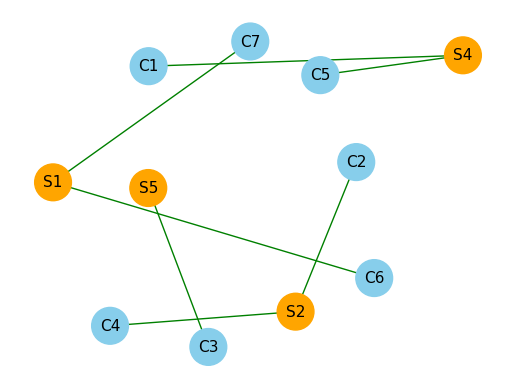

In [49]:
excl_nodes = [s for s, f in assigmnets_storages_to_fields.items() if len(f) == 0]
incl_nodes = list(set(G_fields_storages.nodes) - set(excl_nodes))

plot_graph(G_fields_storages, incl_nodes, assignments, main_nodes='S', save_at='images/storage_field_assignment.svg')

C:\Users\pierp\AppData\Local\Temp\ipykernel_10364\2486720311.py:16: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G_distances, pos, edgelist=incl_edges, width=1, edge_color='green')


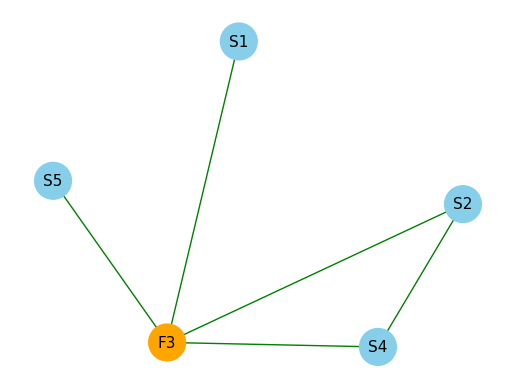

In [50]:
incl_nodes = list(set(G_storages_facility.nodes) - set(excl_nodes))
plot_graph(G_storages_facility, incl_nodes, routes, main_nodes='F', save_at=f'images/routes_from_{facility}.svg')

##### Store Model and Solutions

In [51]:
folder_path = os.getcwd() + f"\\backup\\backup_{facility}_f_{n_fields}_s_{m_storages}\\"
create_folder_if_not_exists(folder_path)

Folder created: c:\Users\pierp\OneDrive\Desktop\Optimization Models\Python exercises\DSSC_MO\backup\backup_F3_f_7_s_6\


In [52]:
larp_model.write(folder_path + 'larp_model.mps')
larp_model.write(folder_path + 'solution.sol')

In [53]:
Y_sol_rapresentation.to_pickle(folder_path + 'Y_sol.pkl')
Z_sol_rapresentation.to_pickle(folder_path + 'Z_sol.pkl')

In [54]:
with open(folder_path + 'list_X_sol.pkl', 'wb') as file:
    pickle.dump(X_sol_rapresentation, file)

In [55]:
with open(folder_path + 'dict_storage_to_fields.pkl', 'wb') as file:
    pickle.dump(assigmnets_storages_to_fields, file)

In [56]:
scalability_unit = [facility, n_fields, m_storages, larp_model_objval, round(larp_model.Runtime, 2)]
with open(folder_path + 'scalability_unit.pkl', 'wb') as file:
    pickle.dump(scalability_unit, file)

In [57]:
larp_model.dispose()
gp.disposeDefaultEnv()

Freeing default Gurobi environment
